# [単語の頻度データからWord Cloudを作成する方法 | 分析ノート](https://analytics-note.xyz/programming/frequencies-word-cloud/)

In [1]:
%cd ~

/root


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from wordcloud import WordCloud

tqdm.pandas()

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [4]:
from work.config.path.livedoor_news_corpus_paths import LivedoorNewsCorpusPaths
from work.config.column_names.livedoor_news_columns import LivedoorNewsColumns
from work.config.path.font_paths import FontPaths
from work.wordcloud.config.wordcloud_data_paths import WordcloudDataPaths

## データ読み込み

In [3]:
filepath = LivedoorNewsCorpusPaths.LIVEDOOR_NEWS_CORPUS_PRP_PATH
df = pd.read_csv(filepath)
df.head(3).T

,0,1,2
text,自由に転載・引用が可能です。このディレクトリの記事ファイル内容の提供元：独女通信http:/...,もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……...,携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だった。恋人と別れたら、手帳に書か...
category,dokujo-tsushin,dokujo-tsushin,dokujo-tsushin
category_label,0,0,0
filtered_text,自由に転載・引用が可能です。このディレクトリの記事ファイル内容の提供元:独女通信,もうすぐジューン・ブライドと呼ばれる6月。独女の中には自分の式はまだなのに呼ばれてばかり.....,携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だった。恋人と別れたら、手帳に書か...
filtered_text_token,自由 転載 引用 可能 ディレクトリ 記事 ファイル 内容 提供元 独女通信,ジューン・ブライド 呼ぶ れる 6月 独女 中 自分 式 呼ぶ れる お祝い 貧乏 状態 人...,携帯電話 普及 する 以前 恋人 連絡 ツール 一般 電話 普通 恋人 別れる 手帳 書く ...


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7376 entries, 0 to 7375
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            7376 non-null   object
 1   category        7376 non-null   object
 2   category_label  7376 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 173.0+ KB


## TF-IDF の計算

In [5]:
documents = df[LivedoorNewsColumns.FILTERED_TEXT_TOKEN]

In [7]:
tokens = df.loc[1010, LivedoorNewsColumns.FILTERED_TEXT_TOKEN]
tokens

'smartphone 携帯電話 タブレット端末 ポータブル ゲーム機 モバイル 機器 持ち歩く いる 人 中 バッテリー 切れ 気 なる 人 いる これら 機器 便利 バッテリー 切れる しまう 何 役 立つ モバイル 機器 バッテリー 気 なる 人 ため モバイル ステーション melkco 製 i mee モバイル 用 スタンダード 容量 バッテリー melkco 製 i mee モバイル 用 大型 容量 バッテリー 発売 開始 する ここ 紹介 する 70g 2000m ah 容量 バッテリー melkco 製 i mee モバイル 用 スタンダード 容量 バッテリー モバイル 機器 向け 開発 する れる 容量 バッテリー smartphone 携帯電話 タブレット端末 ポータブル ゲーム機 様々 機器 対応 する いる 104 x5 5 x1 1mm コンパクト ボディ かかわる 2000m ah 容量 70g 軽い さ 実現 する melkco 製 i mee モバイル 用 スタンダード 容量 バッテリー 主 仕様 タイプリチウムポリマー 入力 dc 5v 出力 dc 5v 最大 1 a 2 ポート 同時 使用可能 容量 2000m ah サイズ 104 x5 5 x1 1mm 重量 70g 青色led ライト x4 電源 ボタン 押す こと 大凡 残 量 知る こと できる 節電 ため スタンバイ 機能 付き 7000m ah 大型 容量 バッテリー melkco 製 i mee モバイル 用 大型 容量 バッテリー 容量 バッテリー 欲しい 人 ため 開発 する れる 大型 容量 バッテリー こちら バッテリー smartphone 携帯電話 タブレット端末 ポータブル ゲーム機 様々 機器 対応 する いる 119 x 73 x1 7mm コンパクト バッテリー 7000m ah 容量 実現 する 重さ 175g カバン 中 入れる 苦 なる melkco 製 i mee モバイル 用 大型 容量 バッテリー 主 仕様 タイプリチウムポリマー 入力 dc 5v 出力 dc 5v 最大 1 a 2 ポート 同時 使用可能 容量 7000m ah サイズ 119 x 73 x1 7mm 重量 175g 青色led ライト x4 電源 ボタン 押す こ

In [8]:
%%time
# tfidfモデルの作成と学習
tfidf_model = TfidfVectorizer(token_pattern="(?u)\\b\\w+\\b", norm=None)
tfidf_model.fit(documents)

# 対象テキストをtf-idfデータに変換
tfidf_vec = tfidf_model.transform([tokens]).toarray()[0]
# 単語: tf-idfの辞書にする。
tfidf_dict = dict(zip(tfidf_model.get_feature_names_out(), tfidf_vec))
# 値が正のkeyだけ残す
tfidf_dict = {k: v for k, v in tfidf_dict.items() if v > 0}

CPU times: user 9.91 s, sys: 0 ns, total: 9.91 s
Wall time: 9.91 s


## WordCloud

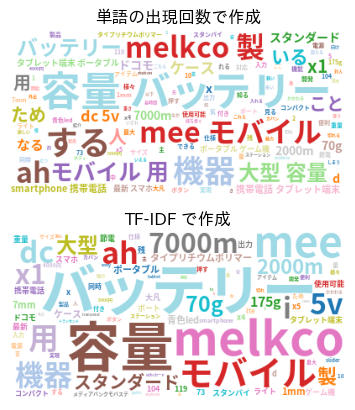

CPU times: user 7.71 s, sys: 532 ms, total: 8.24 s
Wall time: 7.7 s


In [41]:
%%time
font_path = FontPaths.NOTO_SANS_CJK_BOLD_PATH

# 単語の出現頻度で Word Cloud 作成

wc_freq = WordCloud(
    font_path=font_path,
    width=400,
    height=200,
    prefer_horizontal=1,
    background_color="white",
    include_numbers=True,
    colormap="tab20",
    regexp=r"[\w']+",
    random_state=0,
).generate_from_text(tokens)

# TF-IDF で Word Cloud 作成
wc_tfidf = WordCloud(
    font_path=font_path,
    width=400,
    height=200,
    prefer_horizontal=1,
    background_color="white",
    include_numbers=True,
    colormap="tab20",
    # colormap="binary",
    # colormap="flag",
    # colormap="twilight",
    # colormap="Greys",
    regexp=r"[\w']+",
    random_state=0,
).generate_from_frequencies(tfidf_dict)


fig = plt.figure()
ax = fig.add_subplot(2, 1, 1, title="単語の出現回数で作成")
ax.imshow(wc_freq)
ax.axis("off")
ax = fig.add_subplot(2, 1, 2, title="TF-IDF で作成")
ax.imshow(wc_tfidf)
ax.axis("off")
plt.show()

## 関数化

In [54]:
from ctypes import Union
import json
from typing import Dict, Iterable, Optional, Set

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud


class WordCloudGenerator:
    def __init__(self) -> None:
        self.model = None
        self.tfidf_vectorizer = None

    def generate(
        self,
        tokenized_text: Optional[str] = None,
        documents: Optional[Iterable] = None,
        tfidf_dict: Optional[Dict[str, float]] = None,
        tfidf_json_path: Optional[str] = None,
        fig_path: Optional[str] = None,
        font_path: Optional[str] = None,
        title: Optional[str] = None,
        width: int = 400,
        height: int = 200,
        prefer_horizontal: float = 1.0,
        min_font_size: int = 4,
        stopwords: Optional[Set[str]] = None,
        random_state: Optional[int] = 0,
        background_color: str = "white",
        max_font_size: Optional[int] = None,
        font_step: int = 1,
        mode: str = "RGB",
        relative_scaling: Union[float, str] = "auto",
        regexp: Optional[str] = r"[\w']+",
        collocations: bool = True,
        colormap: Optional[str] = None,
        normalize_plurals=True,
        contour_width=0,
        contour_color="black",
        repeat=False,
        include_numbers=True,
        min_word_length=0,
        collocation_threshold=30,
    ) -> dict:
        """
        By default, WordCloud is generated by word frequency.
        Please specify one of the following arguments to generate WordCloud based on TF-IDF:

          - tokenized_text & documents
          - tfidf_dict

        """
        result_dict = {}
        model = WordCloud(
            font_path=font_path,
            width=width,
            height=height,
            prefer_horizontal=prefer_horizontal,
            min_font_size=min_font_size,
            stopwords=stopwords,
            random_state=random_state,
            background_color=background_color,
            max_font_size=max_font_size,
            font_step=font_step,
            mode=mode,
            relative_scaling=relative_scaling,
            regexp=regexp,
            collocations=collocations,
            colormap=colormap,
            normalize_plurals=normalize_plurals,
            contour_width=contour_width,
            contour_color=contour_color,
            repeat=repeat,
            include_numbers=include_numbers,
            min_word_length=min_word_length,
            collocation_threshold=collocation_threshold,
        )
        self.model = model
        tfidf_vectorizer = self.tfidf_vectorizer

        if tfidf_dict is not None:
            generated_wc = model.generate_from_frequencies(tfidf_dict)

        elif (documents is not None) and (tokenized_text is not None):
            tfidf_vectorizer = TfidfVectorizer(token_pattern="(?u)\\b\\w+\\b", norm=None)
            tfidf_vectorizer.fit(documents)
            tfidf_vec = tfidf_vectorizer.transform([tokenized_text]).toarray()[0]
            tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vec))
            tfidf_dict = {k: v for k, v in tfidf_dict.items() if v > 0}

            generated_wc = model.generate_from_frequencies(tfidf_dict)

            if tfidf_json_path is not None:
                f = open(tfidf_json_path, "w")
                json.dump(tfidf_dict, f)
                f.close()

            self.tfidf_vectorizer = tfidf_vectorizer

        elif tokenized_text is not None:
            generated_wc = model.generate_from_text(tokenized_text)

        else:
            raise ValueError(
                "The argument 'tokenized_text' or ('tokenized_text' & 'documents') or 'tfidf_dict' must be specified."
            )

        plt.imshow(generated_wc)
        plt.title(title)
        plt.axis("off")
        plt.show()

        if fig_path is not None:
            model.to_file(fig_path)

        result_dict["wordcloud_model"] = generated_wc
        result_dict["tfidf_dict"] = tfidf_dict
        result_dict["tfidf_vectorizer"] = tfidf_vectorizer

        return result_dict

In [42]:
tokenized_text = df.sample()[LivedoorNewsColumns.FILTERED_TEXT_TOKEN].values[0]
tokenized_text

'男と女 友情 成立 する の 永遠 テーマ しれる 逆 友達 恋人 境目 どこ ある の 体 関係 ある 内科 区別 する れる こと ある 逆 関係 ある いう 恋人 わけ ない 体 関係 セックスフレンド 成立 する 出端 体 関係 ある 友達 よう 何 話せる 関係 場合 友達 恋人 違い なんだろう ナタリー・ポートマン アシュトン・カッチャー 演じる 抱きたいカンケイ よう テーマ 作る れる いる あちら 本作 セックスフレンド 関係 作り 恋人 関係 誰 持つ こと 望む 女 徹底 する 描く れる いる ため 彼ら 目指す いる 関係 明らか 本作 ジェイミー ミラ・クニス ディラン ジャスティン・ティンバーレイク 2人 共 恋人 欲しい 恋愛 下手 振る れる 失恋 する 2人 運命の人 出会う 都合 いい 関係 いる わけ 抱きたいカンケイ 明らか 違う の 2人 ビジネス パートナー こと つまり セックス する 時 会う わけ いく 関係 出会う 時 生まれる しまう いる こと 仕事 上 関係 信頼関係 ある 異性 魅力 感じる いる 2人 友達 セックスフレンド 関係 選択 する 理由 仕事 支障 ない 設定 なる いる 見当たる これ 逆 信頼関係 ある セックス 無理 ステイ・フレンズ 成り立つ 一線 超える られる 重要 両方 あり ステイ・フレンズ 難しい の ない 断言 出来る 前者 難易度 高い はず 角度 変える 2人 見る みる 2人 必要 の セックスフレンド 関係 関係 スタート よう 思える ジェイミー 表面的 強い 女 演じる いる 繊細 運命 王子 様 出会える 日 夢見る いる シンデレラ症候群 一見 軽い 見える ディラン 心 底 運命 相手 求める いる 2人 共通 する いる の 傷つく こと 恐れる あまり 自分 演じる しまう こと セックスフレンド 割り切る 関係 傷 癒す 事 求める の しれる 飾る 関係 スタート 出来る 2人 関係 本物 なる の 思う セックスフレンド 関係 始める 素晴らしい アイデア 思う 自分 演じる 相手 付き合う 位 ジェイミー ディラン 関係 方 純粋 しれる 本物 自分 相手 付き合う こと プライオリティ 考える させる られる 一本 安部沙織'

In [59]:
wordcloud_generator = WordCloudGenerator()

### トークン出現頻度ベース

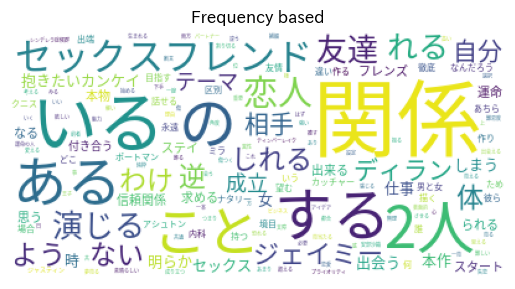

dict_keys(['wordcloud_model', 'tfidf_dict', 'tfidf_vectorizer'])

In [60]:
result_dict = wordcloud_generator.generate(
    tokenized_text=tokenized_text,
    font_path=FontPaths.NOTO_SANS_CJK_REGULAR_PATH,
    title="Frequency based",
    random_state=0,
)
result_dict.keys()

### TF-IDF ベース (documents 指定)

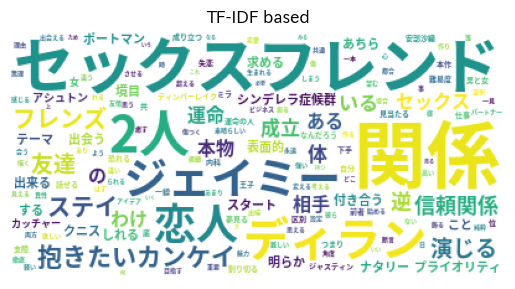

dict_keys(['wordcloud_model', 'tfidf_dict', 'tfidf_vectorizer'])

In [64]:
result_dict = wordcloud_generator.generate(
    tokenized_text=tokenized_text,
    documents=documents,
    font_path=font_path,
    title="TF-IDF based",
    random_state=0,
    prefer_horizontal=1,
)
result_dict.keys()

### TF-IDF ベース (tfidf_dict 指定)

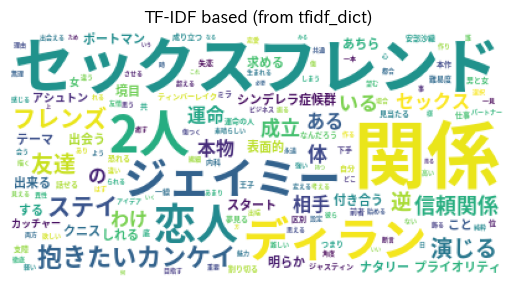

dict_keys(['wordcloud_model', 'tfidf_dict', 'tfidf_vectorizer'])

In [65]:
result_dict = wordcloud_generator.generate(
    font_path=font_path,
    title="TF-IDF based (from tfidf_dict)",
    random_state=0,
    tfidf_dict=result_dict["tfidf_dict"],
    prefer_horizontal=1,
)
result_dict.keys()

### `random_state` を変えるとレイアウトや色の順序が変わる

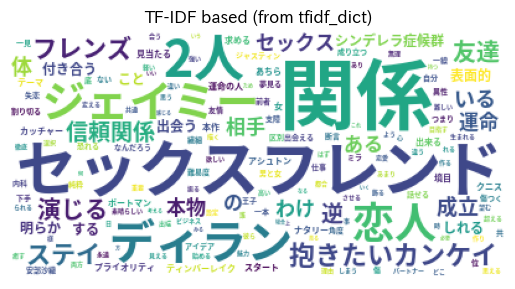

dict_keys(['wordcloud_model', 'tfidf_dict', 'tfidf_vectorizer'])

In [63]:
result_dict = wordcloud_generator.generate(
    font_path=font_path,
    title="TF-IDF based (from tfidf_dict)",
    random_state=42,
    tfidf_dict=result_dict["tfidf_dict"],
)
result_dict.keys()